In [5]:
import matplotlib.pyplot as plt
import numpy as np

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

This function makes nice $\LaTeX$ labels for different final states

In [6]:
def get_tex_label(fs):
    tex_label = r"$"+ fs
    tex_label = tex_label.replace("pi0", "\pi^0")
    tex_label = tex_label.replace("pi pi", "\pi^+ \pi^-")
    tex_label = tex_label.replace("mu mu", "\mu^+ \mu^-")
    tex_label = tex_label.replace("g", "\gamma")
    tex_label = tex_label.replace("e e", "e^+ e^-")
    return tex_label + r"$"

def get_color(fs):
#     fss = sorted(list(set(ScalarMediator.list_final_states() + VectorMediator.list_final_states())))
    fss = ["pi0 pi0", "pi pi", "mu mu", "e e", "pi0 g", "g g", "pi0 pi pi", "s s", "v v"]
    return list(plt.rcParams["axes.prop_cycle"])[fss.index(fs)]["color"]

These imports give access to COMPTEL's energy resolution and a function to convolve a spectrum with a detector's smearing function. We will use these to understand how lines contribute to the spectrum for this model.

In [7]:
from hazma.gamma_ray_parameters import energy_res_comptel

This import loads the vector mediator class from hazma.

In [8]:
from hazma.vector_mediator import VectorMediator
from hazma.scalar_mediator import ScalarMediator
from hazma.parameters import neutral_pion_mass as mpi0

## Spectra's dependence on $m_\chi$
This section examines the dependence of the spectra on the dark matter mass. The dependence on the couplings is less interesting since adjusting them just shifts the normalization of the different final states' contributions.

Create a `VectorMediator` object. The values of couplings to leptons and the strange quark and well as $m_V$ are irrelevant to our focus. The initial value of $m_\chi$ does not matter since it will shortly be changed. The velocity dispersion in the Milky Way $v_\chi \sim 10^{-3}$ is defined here, as it was above.

In [9]:
vm_args = {"mx": 250., "mv": 1000., "gvxx": 1., "gvuu": 1., "gvdd": 0.2, "gvss": 0., "gvee": 0., "gvmumu": 0.}
vm = VectorMediator(**vm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

Choose a less dense array of photon energies from 10 - 250 MeV.

In [10]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250

e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

Create a 2D array of dark matter masses.

In [11]:
n_subplot_rows, n_subplot_cols = 2, 2

mxs = np.array([75., 120., 143., 200.]).reshape((n_subplot_rows, n_subplot_cols))

Iterate over the array of dark matter masses, computing the spectrum at each $E_\gamma \in$ `e_gams`. Most of the code below formats the plot nicely; the `spectra()` function is called in line 12.

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,0.98,'Vector mediator, $g_{Vuu} = 5 g_{Vdd}$')

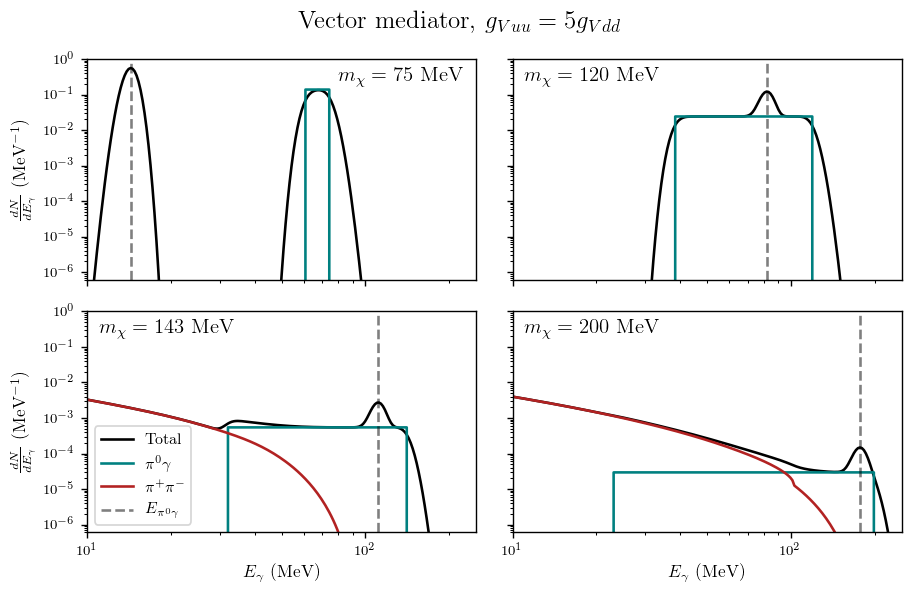

In [12]:
plt.figure(figsize=(7.5, 5))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    vm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*vm.mx * (1. + 0.5 * vx_mw)
    
    # Plot total convolved spectrum
    dnde_det = vm.get_detected_spectrum(e_gam_min, e_gam_max,
                                        e_cm, energy_res=energy_res_comptel)
    plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")
    
    # Plot individual channels' spectra
    for fs, spec in reversed(sorted(vm.spectra(e_gams, e_cm).iteritems())):
        if fs not in ["e e", "mu mu", "total", "v v"]:
            plt.loglog(e_gams, spec, label=get_tex_label(fs), color=get_color(fs), linewidth=1.5)

    # Mark the lines' energies
    for ch, line in vm.gamma_ray_lines(e_cm).iteritems():
        plt.axvline(line["energy"], linestyle='--', color="k", alpha=0.5, linewidth=1.5, label=r"$E_{\pi^0\gamma}$")
    
    ### Formatting
    # Set axis limits
    plt.xlim(10, 250)
    plt.ylim(6e-7, 1e0)
    
    # Only draw the legend for the first subplot
    if idx == 2:
        plt.legend(loc="lower left")
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    if (row_idx, col_idx) == (0, 0):
        plt.text(8e1, 2e-1, r"$m_\chi = %0.f$ MeV" % it[0])
    else:
        plt.text(1.1e1, 2e-1, r"$m_\chi = %0.f$ MeV" % it[0])
    
    it.iternext()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # remove some of the space between plots
plt.suptitle(r"Vector mediator, $g_{Vuu} = %i g_{Vdd}$" % (vm.gvuu/vm.gvdd))

# plt.savefig("figures/vector_spectra.pdf")

## Dependence on couplings

In [13]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [14]:
vm_args = {"mx": 250., "mv": 1000., "gvxx": 1., "gvuu": 1., "gvdd": 0.2, "gvss": 0., "gvee": 0., "gvmumu": 0.}
vm = VectorMediator(**vm_args)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

In [15]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

In [16]:
n_subplot_rows, n_subplot_cols = 2, 2
mxs = np.array([75., 120., 143., 200.]).reshape((n_subplot_rows, n_subplot_cols))

ratios = np.linspace(-2, 1, 10)

In [17]:
# Set up the colormap
cmap = cm.viridis_r
norm = Normalize(vmin=ratios[0], vmax=ratios[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(ratios)

In [18]:
# Compute the spectra!
spectra_det = {}

for mx in mxs.flatten():
    vm.mx = mx  # current value of mx
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*vm.mx * (1. + 0.5 * vx_mw)
    
    for ratio in ratios:
        vm.gvdd = ratio * vm.gvuu
        spec = vm.spectra(e_gams, e_cm)["total"]
        
        dnde_det = vm.get_detected_spectrum(e_gam_min, e_gam_max,
                                            e_cm, energy_res=energy_res_comptel)

        spectra_det[(mx, ratio)] = dnde_det(e_gams)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


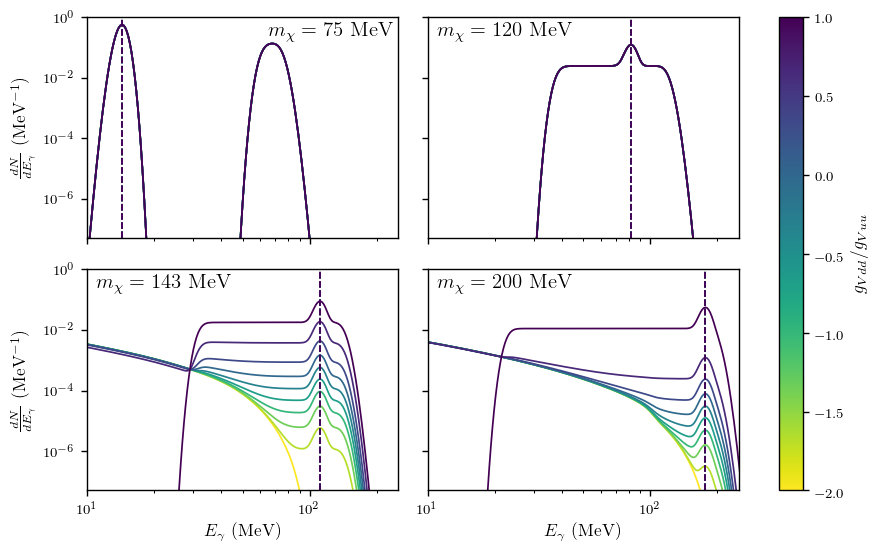

In [19]:
fig, axes = plt.subplots(nrows=n_subplot_rows, ncols=n_subplot_cols, figsize=(7.5, 5), sharex=True, sharey=True)

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    ax = axes[row_idx, col_idx]
    
    for ratio in ratios:
        ax.loglog(e_gams, spectra_det[(float(it[0]), ratio)], color=m.to_rgba(ratio), linewidth=1)
        e_cm = 2.*it[0] * (1. + 0.5 * vx_mw)
        ax.axvline((e_cm**2 - mpi0**2) / (2. * e_cm), linestyle='--', color=m.to_rgba(ratio), linewidth=1)
    
    ### Formatting
    # Set axis limits
    plt.xlim(10, 250)
    plt.ylim(5e-8, 1e0)

    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        ax.tick_params(labelbottom="off")
    else:
        ax.set_xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        ax.tick_params(labelleft="off")
    else:
        ax.set_ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")

    # Label subplot with dark matter mass
    if (row_idx, col_idx) == (0, 0):
        ax.text(6.5e1, 2e-1, r"$m_\chi = %0.f$ MeV" % it[0])
    else:
        ax.text(1.1e1, 2e-1, r"$m_\chi = %0.f$ MeV" % it[0])
    
    it.iternext()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # remove some of the space between plots
# plt.suptitle(r"Vector mediator")

fig.colorbar(m, ax=axes.ravel().tolist()).set_label(r"$g_{Vdd} / g_{Vuu}$")

plt.savefig("figures/vector_spectra_coupling_dependence.pdf")